In [1]:
import os
import numpy as np
np.random.seed(42)

import pandas as pd

import cytopath
import scvelo as scv
import scanpy as scp

from scipy import stats

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Import pancreatic endocrinogenesis dataset from scvelo
adata = scv.datasets.pancreatic_endocrinogenesis()

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

In [3]:
# Process data and estimate velocity
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000) # Filters from scvelo tutorial
scv.pp.moments(adata)
scv.tl.velocity(adata)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [4]:
# Estimate the cosine similarities between a cell's velocity vector and connectivity to it's neighbors
scv.tl.velocity_graph(adata, mode_neighbors='connectivities')

# Estimate the transition probability matrix by normalizing the velocity graph excluding self transitions 
adata.uns['T_forward'] = scv.utils.get_transition_matrix(adata, self_transitions=False)

computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


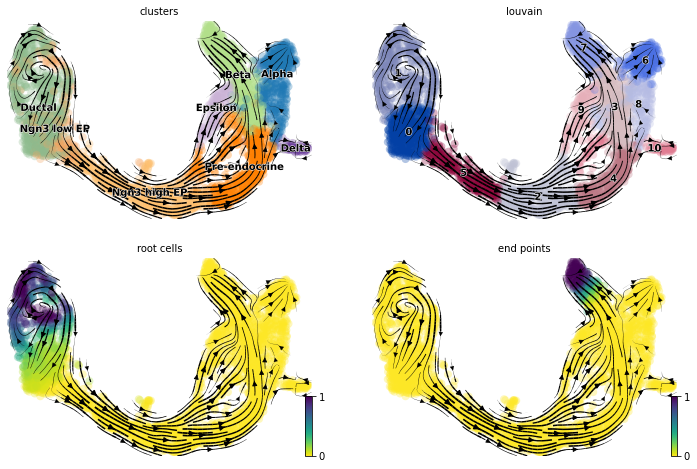

In [5]:
# Estimate the terminal states, louvain clustering and velocity embedding
scv.tl.terminal_states(adata)
scv.tl.louvain(adata)
scv.tl.velocity_embedding(adata, basis='umap')

scv.pl.velocity_embedding_stream(adata, color=['clusters', 'louvain', 'root_cells', 'end_points'],
                                             ncols=2, legend_loc='on data')


In [6]:
# Generate simulations of lineage development
cytopath.sampling(adata, num_cores=os.cpu_count()-1)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 1784
Number of initial simulations (sim_number) set to 1784
Number of initial simulation steps (max_steps) set to 18

Sampling round: 0


  0%|          | 0/81 [00:00<?, ?it/s]

0.11 % of required simulations obtained for lagging end point 7. This is less than min_sim_ratio.
0.0014 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 112.

Sampling round: 1


  0%|          | 0/81 [00:00<?, ?it/s]

Sampling done.


In [7]:
# Infer trajectories (by default the louvain cluster in which terminal cells occur is assumed to be their identity)
cytopath.trajectories(adata, num_cores=os.cpu_count()-1)

Stage 1 clustering done. Aligning clusters for end point 7
Calculating hausdorff distances


  0%|          | 0/1784 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/461 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point 7


  0%|          | 0/461 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point 7 at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  7


  0%|          | 0/3152 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  7 (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

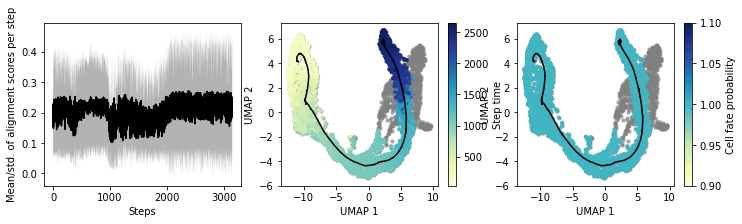

In [8]:
# Plot allignment and trajectories
cytopath.plot_trajectories(adata, directory='', basis='umap')

In [9]:
# Alternatively if clustering is known then supply the known root and end points
# This can be done by supplying numerical index of root/end cells, root/end clusters or a manual probability threshold
cytopath.sampling(adata, cluster_key='clusters',
                  end_clusters=['Alpha', 'Beta', 'Epsilon', 'Delta'],
                  num_cores=os.cpu_count()-1)

cytopath.trajectories(adata, num_cores=os.cpu_count()-1)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 1784
Number of initial simulations (sim_number) set to 7136
Number of initial simulation steps (max_steps) set to 18

Sampling round: 0


  0%|          | 0/81 [00:00<?, ?it/s]

1.4 % of required simulations obtained for lagging end point Delta. This is less than min_sim_ratio.
0.1334 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 87.

Sampling round: 1


  0%|          | 0/81 [00:00<?, ?it/s]

97.53 % of required simulations obtained for lagging end point Epsilon.
58.5902 % of simulations reached atleast one endpoint. Generating 7136 additional samples.

Sampling round: 2


  0%|          | 0/81 [00:00<?, ?it/s]

Sampling done.
Stage 1 clustering done. Aligning clusters for end point Alpha
Calculating hausdorff distances


  0%|          | 0/1784 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/284 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point Alpha


  0%|          | 0/284 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Stage 1 clustering done. Aligning clusters for end point Beta
Calculating hausdorff distances


  0%|          | 0/1784 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/167 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point Beta


  0%|          | 0/167 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Stage 1 clustering done. Aligning clusters for end point Delta
Calculating hausdorff distances


  0%|          | 0/1784 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/105 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point Delta


  0%|          | 0/105 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Stage 1 clustering done. Aligning clusters for end point Epsilon
Calculating hausdorff distances


  0%|          | 0/1784 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/188 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point Epsilon


  0%|          | 0/188 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point Alpha at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  Alpha


  0%|          | 0/1950 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  Alpha (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point Beta at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  Beta


  0%|          | 0/2082 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  Beta (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point Delta at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  Delta


  0%|          | 0/2414 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  Delta (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point Epsilon at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  Epsilon


  0%|          | 0/2117 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  Epsilon (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

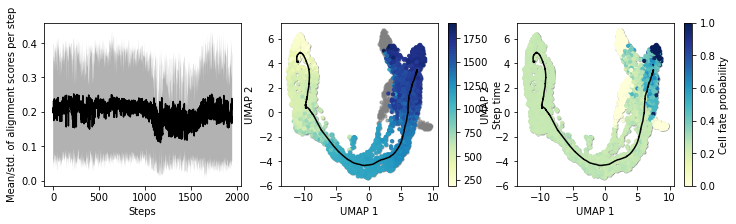

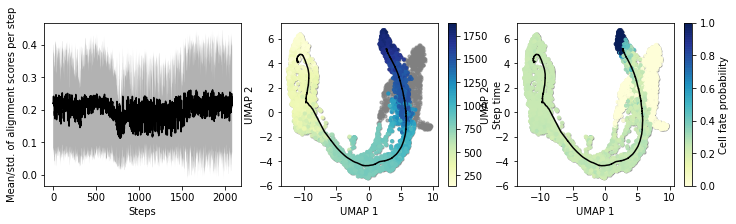

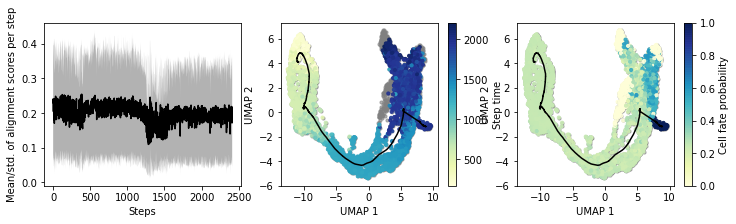

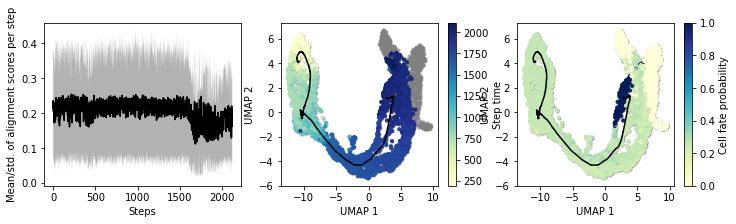

In [10]:
# Plot allignment and trajectories
cytopath.plot_trajectories(adata, directory='', basis='umap')

In [11]:
# Cell cycle genes
cell_cycle_genes = {
    
    'G1/S': ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7',
             'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN',
             'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45',
             'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1',
             'CHAF1B', 'BRIP1', 'E2F8'],
    'G2/M': ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 
             'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1',
              'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 
              'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA',
              'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
}

In [12]:
# Cell cycle scoring
adata_ = adata[adata.obs.loc[adata.obs.louvain.isin(['1', '0'])].index.values]

g1s_genes = np.array(cell_cycle_genes['G1/S'], dtype='<U5')
g1s_genes = g1s_genes[~(g1s_genes == 'nan')]

g1s_genes = list(gene[0]+gene[1:].lower() for gene in g1s_genes)

g2m_genes = np.array(cell_cycle_genes['G2/M'], dtype='<U5')
g2m_genes = g2m_genes[~(g2m_genes == 'nan')]

g2m_genes = list(gene[0]+gene[1:].lower() for gene in g2m_genes)

scp.tl.score_genes_cell_cycle(adata_, s_genes=g1s_genes, g2m_genes=g2m_genes)

Trying to set attribute `.obs` of view, copying.


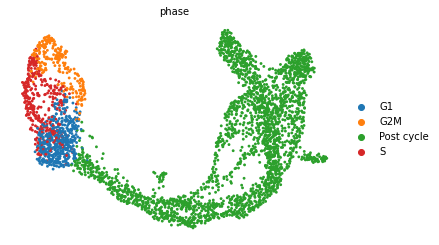

In [13]:
# Plot cell type phase
adata.obs['phase'] = 'Post cycle'
adata.obs.loc[adata_.obs.index.values, 'phase'] = adata_.obs.phase.values

scv.pl.umap(adata, color='phase', legend_loc = 'right')

<AxesSubplot:xlabel='Step', ylabel='Density'>

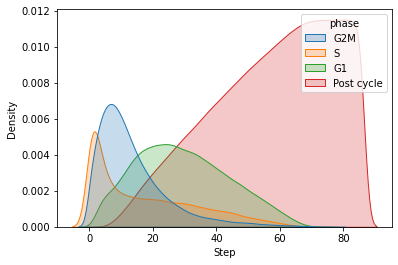

In [14]:
# Cell cycle phase for each simulation step
sample_phase_transitions = np.empty(adata.uns['samples']['cluster_sequences'].shape, dtype='U32')
for j in range(sample_phase_transitions.shape[0]):
    sample_phase_transitions[j] = adata.obs.iloc[adata.uns['samples']['cell_sequences'][j], adata.obs.columns.get_loc('phase')]
    
temp = pd.DataFrame(sample_phase_transitions).melt(var_name='Step', value_name='phase')
sns.kdeplot(x='Step', hue='phase', data=temp, fill=True)

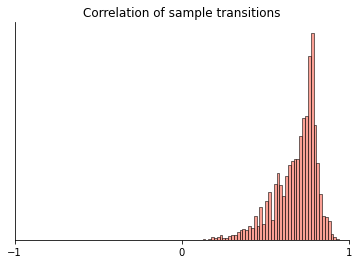

In [15]:
# Individual sample correlations
correls = []
data = pd.DataFrame(sample_phase_transitions)

for sample in range(data.shape[0]):
    phase_ = data.iloc[sample, :].apply(['G1', 'S', 'G2M', 'Post cycle'].index)
    correls.append(stats.spearmanr(np.arange(len(phase_)), phase_)[0])

# Distribution of sample correlations
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_title('Correlation of sample transitions')
sns.histplot(correls, ax=ax, color='salmon')
ax.set_xlim([-1,1])
ax.set_xticks([-1,0,1])
ax.yaxis.set_visible(False)
sns.despine(ax=ax)


Sampling round: 0


  0%|          | 0/3696 [00:00<?, ?it/s]

Sampling done.


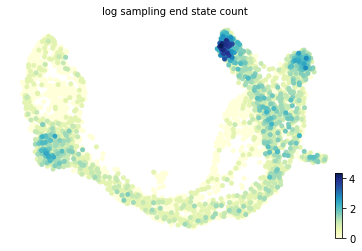

In [16]:
# Undirected sampling
adata.obs['all_end'] = 'end'
adata.obs['all_end'] = adata.obs['all_end'].astype('category')
# Initialise samples randomnly
cytopath.sampling(adata, auto_adjust=False, max_steps=30, 
                  root_cells=np.arange(adata.shape[0]), 
                  end_points=np.arange(adata.shape[0]),
                  sim_number=5000, traj_number=5000,
                  cluster_key='all_end', min_clusters=1,
                  num_cores=os.cpu_count()-1)

# Plot end points counts per cell of samples
cells, counts = np.unique(adata.uns['samples']['cell_sequences'][:,-1], return_counts=True)

adata.obs['log_sampling_end_state_count'] = 0
adata.obs.iloc[cells, adata.obs.columns.get_loc('log_sampling_end_state_count')] = np.log(counts+1)

adata.obs['sampling_end_state_count'] = 0
adata.obs.iloc[cells, adata.obs.columns.get_loc('sampling_end_state_count')] = counts

scv.pl.umap(adata, color='log_sampling_end_state_count',  color_map='YlGnBu', size=100, legend_loc=False)

In [17]:
# Cytopath data is stored under the following keys

# Summarised cell level data (core TI output for a typical usecase)
adata.uns['trajectories']['cells_along_trajectories']

# Pseduotime data and cell alignment at the most granular level i.e. all alignments of cells for all steps
# Useful when dealing with looping trajectories
adata.uns['trajectories']['cells_along_trajectories_each_step']

# Simulations numerical cell IDs, simulation scores, cluster identity of simulation steps
adata.uns['samples']

# Trajectory data including coordinates
adata.uns['trajectories']

{'trajectories_coordinates': {'Alpha': {'trajectory_0_coordinates': [array([-10.86543443,   4.16415562]),
    array([-10.8751009 ,   4.15724919]),
    array([-10.87131208,   4.15326676]),
    array([-10.87287127,   4.15066265]),
    array([-10.87269188,   4.14887467]),
    array([-10.88277747,   4.14722358]),
    array([-10.88572824,   4.14642123]),
    array([-10.88606563,   4.14270772]),
    array([-10.8855661 ,   4.14057156]),
    array([-10.88888657,   4.13709127]),
    array([-10.89021685,   4.1326412 ]),
    array([-10.88999472,   4.1322502 ]),
    array([-10.89359421,   4.13013483]),
    array([-10.89254857,   4.13144082]),
    array([-10.89049597,   4.13171717]),
    array([-10.88868355,   4.13070999]),
    array([-10.88779875,   4.13021709]),
    array([-10.88773135,   4.13110584]),
    array([-10.88782268,   4.1309331 ]),
    array([-10.88735592,   4.12835509]),
    array([-10.88591756,   4.1280837 ]),
    array([-10.88616322,   4.12726858]),
    array([-10.88584126,   4.1273